In [1]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import requests


warnings.filterwarnings("ignore")
sns.set(style="whitegrid")

def load_data(db_name="vacancies.db"):
    conn = sqlite3.connect(db_name)
    query = "SELECT * FROM vacancies"
    df = pd.read_sql_query(query, conn)
    conn.close()
    return df

data = load_data()
print(f"Размер данных: {data.shape}")
print(data.head())


Размер данных: (525, 15)
          id                                               name  \
0  111851213                                    Аналитик данных   
1  114259068                                    Аналитик данных   
2  111501182  Аналитик данных (BI-аналитик/Финансовый аналит...   
3  112965264                         Аналитик данных телеметрии   
4  111847179  Менеджер по продажам образования по Искусствен...   

         area_name  salary_from  salary_to salary_currency published_at  \
0        Краснодар      65000.0    65000.0             RUR   2024-12-20   
1     Екатеринбург     100000.0   100000.0             RUR   2024-12-20   
2     Екатеринбург     180000.0   220000.0             RUR   2024-12-20   
3          Воронеж      75000.0    75000.0             RUR   2024-12-20   
4  Санкт-Петербург     150000.0   400000.0             RUR   2024-12-20   

                           employer_name                    alternate_url  \
0              ПКО Служба защиты активов  ht

In [2]:
data["published_at"] = pd.to_datetime(data["published_at"], errors="coerce")
data["published_at"] = data["published_at"].dt.date
data = data.dropna(subset=['snippet_requirement', 'snippet_responsibility'])
data['salary_to'] = data['salary_to'].fillna(data['salary_from'])
data = data.dropna(subset=["salary_from"])
data.head()

,id,name,area_name,salary_from,salary_to,salary_currency,published_at,employer_name,alternate_url,snippet_requirement,snippet_responsibility,professional_roles,schedule,employment,experience
0,111851213,Аналитик данных,Краснодар,65000.0,65000.0,RUR,2024-12-20,ПКО Служба защиты активов,https://hh.ru/vacancy/111851213,Получаете удовольствие от работы с большими да...,Анализ данных по действующим клиентам. Выгрузк...,"BI-аналитик, аналитик данных",Полный день,Полная занятость,От 1 года до 3 лет
1,114259068,Аналитик данных,Екатеринбург,100000.0,100000.0,RUR,2024-12-20,ТД Урал-К,https://hh.ru/vacancy/114259068,Высшее профильное образование. Стаж работы в д...,"Формирование финансовый моделей, системы сбала...","BI-аналитик, аналитик данных",Полный день,Полная занятость,От 3 до 6 лет
2,111501182,Аналитик данных (BI-аналитик/Финансовый аналит...,Екатеринбург,180000.0,220000.0,RUR,2024-12-20,Селлер Капитал,https://hh.ru/vacancy/111501182,Опыт работы аналитиком данных или финансовым а...,Анализ финансовой отчетности и создание прогно...,"BI-аналитик, аналитик данных",Полный день,Полная занятость,От 3 до 6 лет
3,112965264,Аналитик данных телеметрии,Воронеж,75000.0,75000.0,RUR,2024-12-20,SUCDEN,https://hh.ru/vacancy/112965264,Желание обучаться и развиваться. Работа с боль...,"Сбор, проверка данных полученных от инженеров ...",Другое,Полный день,Полная занятость,От 1 года до 3 лет
4,111847179,Менеджер по продажам образования по Искусствен...,Санкт-Петербург,150000.0,400000.0,RUR,2024-12-20,Университет искусственного интеллекта,https://hh.ru/vacancy/111847179,Опыт продаж от 2 лет (B2C опыт будет плюсом). ...,Проводить «тёплые» продажи через Zoom-презента...,"Менеджер по продажам, менеджер по работе с кли...",Удаленная работа,Полная занятость,От 1 года до 3 лет


In [3]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

# Функция для получения курса обмена валюты по указанной дате и коду валюты
def get_exchange_rate(date, currency_code):
    url = f"https://www.cbr.ru/scripts/XML_daily.asp?date_req={date}"
    response = requests.get(url)
    if response.status_code == 200:
        soup = BeautifulSoup(response.content, "xml")
        for valute in soup.find_all("Valute"):
            if valute.CharCode.text == currency_code:
                return float(valute.Value.text.replace(",", ".")) / int(valute.Nominal.text)
    return 1  # Возвращаем 1, если курс не найден (например, для RUR или ошибок запроса)

# Преобразуем столбец даты
data["published_at"] = pd.to_datetime(data["published_at"], errors="coerce")
data["published_at"] = data["published_at"].dt.date

# Функция для перевода зарплаты в RUR
def convert_salary_to_rur(row):
    if row['salary_currency'] != "RUR":
        exchange_rate = get_exchange_rate(row['published_at'].strftime("%d/%m/%Y"), row['salary_currency'])
    else:
        exchange_rate = 1  # Если валюта уже RUR, курс = 1
    
    # Переводим зарплату
    salary_from_rur = row['salary_from'] * exchange_rate if pd.notnull(row['salary_from']) else None
    salary_to_rur = row['salary_to'] * exchange_rate if pd.notnull(row['salary_to']) else None
    
    return pd.Series([salary_from_rur, salary_to_rur, "RUR"])

# Применяем функцию к данным
data[['salary_from', 'salary_to', 'salary_currency']] = data.apply(convert_salary_to_rur, axis=1)

# Просмотр результатов
print(data.head())


          id                                               name  \
0  111851213                                    Аналитик данных   
1  114259068                                    Аналитик данных   
2  111501182  Аналитик данных (BI-аналитик/Финансовый аналит...   
3  112965264                         Аналитик данных телеметрии   
4  111847179  Менеджер по продажам образования по Искусствен...   

         area_name  salary_from  salary_to salary_currency published_at  \
0        Краснодар      65000.0    65000.0             RUR   2024-12-20   
1     Екатеринбург     100000.0   100000.0             RUR   2024-12-20   
2     Екатеринбург     180000.0   220000.0             RUR   2024-12-20   
3          Воронеж      75000.0    75000.0             RUR   2024-12-20   
4  Санкт-Петербург     150000.0   400000.0             RUR   2024-12-20   

                           employer_name                    alternate_url  \
0              ПКО Служба защиты активов  https://hh.ru/vacancy/11185

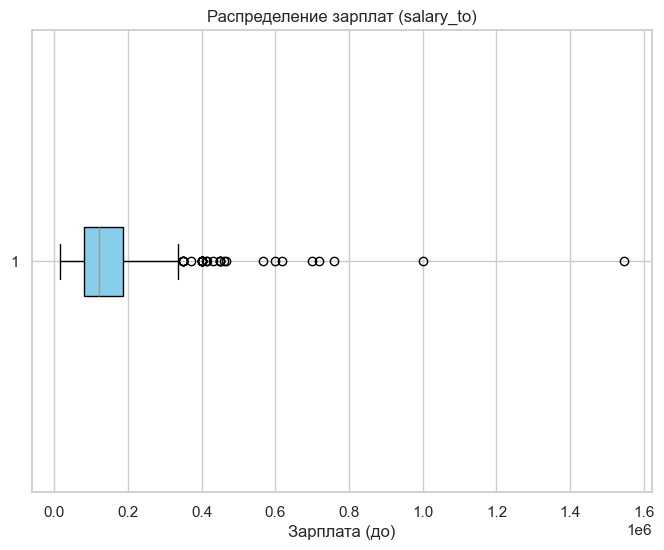

In [4]:
import matplotlib.pyplot as plt


# Построение ящика с усами
plt.figure(figsize=(8, 6))
plt.boxplot(data['salary_to'], vert=False, patch_artist=True, boxprops=dict(facecolor='skyblue', color='black'))

# Настройка заголовка и меток
plt.title("Распределение зарплат (salary_to)")
plt.xlabel("Зарплата (до)")

# Отображение графика
plt.show()


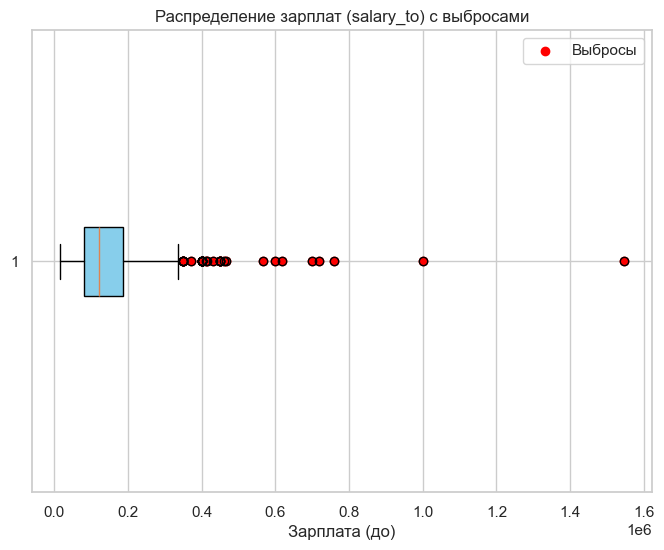

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Извлечение данных для столбца salary_to
salary_to_data = data['salary_to'].dropna()

# Вычисление квартилей и межквартильного размаха (IQR)
Q1 = np.percentile(salary_to_data, 25)
Q3 = np.percentile(salary_to_data, 75)
IQR = Q3 - Q1

# Вычисление пороговых значений для выбросов
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Определение выбросов (весь экземпляр данных, где salary_to является выбросом)
outliers = data[(data['salary_to'] < lower_bound) | (data['salary_to'] > upper_bound)]

# Построение ящика с усами
plt.figure(figsize=(8, 6))
plt.boxplot(salary_to_data, vert=False, patch_artist=True, boxprops=dict(facecolor='skyblue', color='black'))

# Добавление выбросов на график
plt.scatter(outliers['salary_to'], np.ones_like(outliers['salary_to']), color='red', label='Выбросы')

# Настройка заголовка и меток
plt.title("Распределение зарплат (salary_to) с выбросами")
plt.xlabel("Зарплата (до)")
plt.legend()

# Отображение графика
plt.show()



In [6]:
outliers

,id,name,area_name,salary_from,salary_to,salary_currency,published_at,employer_name,alternate_url,snippet_requirement,snippet_responsibility,professional_roles,schedule,employment,experience
4,111847179,Менеджер по продажам образования по Искусствен...,Санкт-Петербург,150000.00,400000.00,RUR,2024-12-20,Университет искусственного интеллекта,https://hh.ru/vacancy/111847179,Опыт продаж от 2 лет (B2C опыт будет плюсом). ...,Проводить «тёплые» продажи через Zoom-презента...,"Менеджер по продажам, менеджер по работе с кли...",Удаленная работа,Полная занятость,От 1 года до 3 лет
5,111847107,Менеджер по продажам образования по Искусствен...,Москва,150000.00,400000.00,RUR,2024-12-20,Университет искусственного интеллекта,https://hh.ru/vacancy/111847107,Опыт продаж от 2 лет (B2C опыт будет плюсом). ...,Проводить «тёплые» продажи через Zoom-презента...,"Менеджер по продажам, менеджер по работе с кли...",Удаленная работа,Полная занятость,От 1 года до 3 лет
18,114183369,Senior Data engineer,Москва,400000.00,400000.00,RUR,2024-12-19,Мамаева Ирина Анатольевна,https://hh.ru/vacancy/114183369,Опыт промышленной разработки на Python от 4х л...,Решение ad-hoc задач от аналитиков и датасаент...,"Программист, разработчик",Удаленная работа,Полная занятость,От 3 до 6 лет
33,112829243,Менеджер по продажам образования по Искусствен...,Сочи,150000.00,400000.00,RUR,2024-12-19,Университет искусственного интеллекта,https://hh.ru/vacancy/112829243,Кандидатов с опытом продаж от 2 лет. Опыт рабо...,Превращать обращения клиентов (в среднем 3-4 Z...,"Менеджер по продажам, менеджер по работе с кли...",Удаленная работа,Полная занятость,От 1 года до 3 лет
90,113462079,ML инженер / Data Scientist (Стартап),Москва,30000.00,1000000.00,RUR,2024-12-14,Марченко Вячеслав Вадимович,https://hh.ru/vacancy/113462079,AI ECOSYSTEM — динамично развивающаяся компани...,Задачи: Анализ данных и создание моделей машин...,Дата-сайентист,Удаленная работа,Полная занятость,От 3 до 6 лет
94,113884185,Team Lead - Machine Learning (Computer Vision),Москва,250000.00,600000.00,RUR,2024-12-17,Русецкий Максим Юрьевич,https://hh.ru/vacancy/113884185,Базы данных: опыт работы с реляционными и нере...,Разработка архитектуры и управление проектами ...,Руководитель группы разработки,Удаленная работа,Полная занятость,От 3 до 6 лет
99,112879107,Системный аналитик,Москва,250000.00,350000.00,RUR,2024-12-19,Centicore,https://hh.ru/vacancy/112879107,...системным аналитиком от 3 лет. — Знание кли...,Работа в аккредитованной IT компании.,Системный аналитик,Полный день,Полная занятость,От 3 до 6 лет
118,109640670,Senior Data Engineer,Москва,350000.00,450000.00,RUR,2024-12-17,Ит-Финанс,https://hh.ru/vacancy/109640670,Опыт работы на позиции Data Engineer - от 4-х ...,Участвовать в проектирование Data Lake. Разраб...,Системный инженер,Удаленная работа,Полная занятость,От 3 до 6 лет
142,113149818,Teamlead Системный аналитик,Москва,350000.00,450000.00,RUR,2024-12-19,ABCP,https://hh.ru/vacancy/113149818,...системного аналитика не менее 3-х лет. Знан...,Управлять командой аналитиков. Интервьюировать...,Системный аналитик,Удаленная работа,Полная занятость,От 3 до 6 лет
154,111768474,Strong Senior Python Engineer,Москва,542541.50,759558.10,RUR,2024-12-19,Betby,https://hh.ru/vacancy/111768474,"...DBMS, ensuring efficient data storage and r...",Develop Web Services and Components: Leverage ...,"Программист, разработчик",Полный день,Полная занятость,Более 6 лет


In [14]:
from transformers import pipeline
import pandas as pd
from tqdm import tqdm
# Загрузка модели для NER
ner_pipeline = pipeline("ner", model="Davlan/bert-base-multilingual-cased-ner-hrl")

tqdm.pandas()

# Функция для извлечения сущностей с использованием NER
def extract_skills_transformers(text):
    ner_results = ner_pipeline(text)
    # Ищем сущности категории 'MISC', которые обычно включают технологии или навыки
    skills = [result['word'] for result in ner_results if result['entity'] == 'MISC']
    return ', '.join(skills)

# Применяем функцию к столбцам snippet_requirement и snippet_responsibility
data['extracted_skills_requirement'] = data['snippet_requirement'].apply(extract_skills_transformers)
data['extracted_skills_responsibility'] = data['snippet_responsibility'].apply(extract_skills_transformers)

# Вывод результата
data


Device set to use cpu


,id,name,area_name,salary_from,salary_to,salary_currency,published_at,employer_name,alternate_url,snippet_requirement,snippet_responsibility,professional_roles,schedule,employment,experience,extracted_skills_requirement,extracted_skills_responsibility
0,111851213,Аналитик данных,Краснодар,65000.0,65000.0,RUR,2024-12-20,ПКО Служба защиты активов,https://hh.ru/vacancy/111851213,Получаете удовольствие от работы с большими да...,Анализ данных по действующим клиентам. Выгрузк...,"BI-аналитик, аналитик данных",Полный день,Полная занятость,От 1 года до 3 лет,,
1,114259068,Аналитик данных,Екатеринбург,100000.0,100000.0,RUR,2024-12-20,ТД Урал-К,https://hh.ru/vacancy/114259068,Высшее профильное образование. Стаж работы в д...,"Формирование финансовый моделей, системы сбала...","BI-аналитик, аналитик данных",Полный день,Полная занятость,От 3 до 6 лет,,
2,111501182,Аналитик данных (BI-аналитик/Финансовый аналит...,Екатеринбург,180000.0,220000.0,RUR,2024-12-20,Селлер Капитал,https://hh.ru/vacancy/111501182,Опыт работы аналитиком данных или финансовым а...,Анализ финансовой отчетности и создание прогно...,"BI-аналитик, аналитик данных",Полный день,Полная занятость,От 3 до 6 лет,,
3,112965264,Аналитик данных телеметрии,Воронеж,75000.0,75000.0,RUR,2024-12-20,SUCDEN,https://hh.ru/vacancy/112965264,Желание обучаться и развиваться. Работа с боль...,"Сбор, проверка данных полученных от инженеров ...",Другое,Полный день,Полная занятость,От 1 года до 3 лет,,
4,111847179,Менеджер по продажам образования по Искусствен...,Санкт-Петербург,150000.0,400000.0,RUR,2024-12-20,Университет искусственного интеллекта,https://hh.ru/vacancy/111847179,Опыт продаж от 2 лет (B2C опыт будет плюсом). ...,Проводить «тёплые» продажи через Zoom-презента...,"Менеджер по продажам, менеджер по работе с кли...",Удаленная работа,Полная занятость,От 1 года до 3 лет,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
520,111888455,Аналитик(ученик менеджера по маркетплейсам),Иваново (Ивановская область),50000.0,50000.0,RUR,2024-12-18,РегионПерсонал,https://hh.ru/vacancy/111888455,Опыт работы в 1с и excel. Грамотная устная и п...,"...таблицами по выпуску изделий,отгрузкам клие...","Оператор ПК, оператор базы данных",Полный день,Полная занятость,От 1 года до 3 лет,,
521,111438224,Маркетолог - аналитик (маркетплейсы),Санкт-Петербург,130000.0,130000.0,RUR,2024-12-17,ТРИТО,https://hh.ru/vacancy/111438224,"Умение работать с большими объемами данных, ан...",Формирование аналитических отчетов по различны...,Маркетолог-аналитик,Полный день,Полная занятость,От 3 до 6 лет,,
522,112418308,Бизнес-аналитик на мобильные приложения,Москва,150000.0,200000.0,RUR,2024-12-18,UFS.travel,https://hh.ru/vacancy/112418308,"Знание особенностей реализации функционала, ха...",Ведение наших мобильных приложений в части биз...,Бизнес-аналитик,Удаленная работа,Полная занятость,От 3 до 6 лет,,
523,108809626,Администратор баз данных,Нальчик,45000.0,45000.0,RUR,2024-12-16,Капитал Медицинское Страхование,https://hh.ru/vacancy/108809626,В организацию требуется разработчик баз данных...,Основная задача - выборка данных для формирова...,"Программист, разработчик",Полный день,Полная занятость,От 1 года до 3 лет,,


In [16]:
data["extracted_skills_requirement"].unique()

array([''], dtype=object)

In [7]:
# import pandas as pd
# import re
# from keybert import KeyBERT
# from spacy.lang.ru.stop_words import STOP_WORDS as RUSSIAN_STOP_WORDS
# from tqdm import tqdm
# import spacy

# warnings.filterwarnings("ignore")

# import spacy.cli
# spacy.cli.download("ru_core_news_sm")

# # Загружаем модель spaCy для русского языка
# nlp = spacy.load('ru_core_news_sm')

# # Функция для очистки текста
# def clean_text(text):
#     if pd.isnull(text):
#         return text
#     text = re.sub(r'<[^>]+>', '', text)  # Удаляем HTML-теги
#     text = re.sub(r'\s+', ' ', text).strip()  # Удаляем лишние пробелы
#     return text

# # Функция для лемматизации текста
# def lemmatize_text(text):
#     doc = nlp(text)
#     # Лемматизируем все токены и объединяем их в строку
#     return ' '.join([token.lemma_ for token in doc])

# # Очистка данных
# data['snippet_requirement'] = data['snippet_requirement'].apply(clean_text)
# data['snippet_responsibility'] = data['snippet_responsibility'].apply(clean_text)

# # Лемматизация текста перед анализом
# data['snippet_requirement'] = data['snippet_requirement'].apply(lemmatize_text)
# data['snippet_responsibility'] = data['snippet_responsibility'].apply(lemmatize_text)

# # Инициализация модели KeyBERT
# model = KeyBERT(model='DeepPavlov/rubert-base-cased')

# # Функция для извлечения ключевых слов с использованием KeyBERT
# def extract_keybert_keywords(text, ngram_range=(1, 3), top_n=10):
#     if pd.isnull(text) or len(text.strip()) == 0:
#         return ''
#     keywords = model.extract_keywords(
#         text,
#         keyphrase_ngram_range=ngram_range,  # Диапазон n-грамм
#         stop_words=list(RUSSIAN_STOP_WORDS),  # Стоп-слова для русского языка
#         top_n=top_n  # Количество ключевых слов/словосочетаний
#     )
#     return ', '.join([kw[0] for kw in keywords])

# # Использование tqdm для отображения прогресса
# tqdm.pandas(desc="Extracting keywords for requirements")
# data['keywords_requirement_keybert'] = data['snippet_requirement'].progress_apply(
#     lambda x: extract_keybert_keywords(x)
# )

# tqdm.pandas(desc="Extracting keywords for responsibilities")
# data['keywords_responsibility_keybert'] = data['snippet_responsibility'].progress_apply(
#     lambda x: extract_keybert_keywords(x)
# )
# 